In [18]:
import os

os.chdir('/home/jwdase/projects/language-detection/src')

DEVICE = 'cuda'

In [29]:
import glob 

base = "/om2/user/moshepol/prosody/models/test/prosody/"

inputs = glob.glob(f'{base}/inputs*.pt')
lengths = glob.glob(f'{base}/lengths*.pt')
labels = glob.glob(f'{base}/outputs*.pt')

In [30]:
print(f'Total Inputs: {len(inputs)}')
print(f'Total Lengths: {len(lengths)}')
print(f'Total Outputs: {len(labels)}')

Total Inputs: 25
Total Lengths: 25
Total Outputs: 25


In [31]:
import torch
from torch.utils.data import TensorDataset, DataLoader, ConcatDataset

from language_detection.model.dataset import AudioDataset

dataset = AudioDataset()


for i, (inp, leng, out) in enumerate(zip(inputs, lengths, labels)):
    if i % 5 == 0:
        print(inp.split('/')[-1])
        print(leng.split('/')[-1])
        print(out.split('/')[-1])


    inputs = torch.load(inp, weights_only=False)
    lengths = torch.load(leng, weights_only=False)
    labels = torch.load(out, weights_only=False)

    for inp, leng, lab in zip(inputs, lengths, labels):
        dataset.additem(inp, leng, lab)

inputs_0.pt
lengths_0.pt
outputs_0.pt
inputs_13.pt
lengths_13.pt
outputs_13.pt
inputs_18.pt
lengths_18.pt
outputs_18.pt
inputs_22.pt
lengths_22.pt
outputs_22.pt
inputs_5.pt
lengths_5.pt
outputs_5.pt


In [32]:
loader = DataLoader(dataset, batch_size=64, num_workers=4, shuffle=False)

In [33]:
print(f'Shape is: {dataset.get_shape()}')
print(f'Files: {len(dataset)}')

Shape is: torch.Size([20, 297])
Files: 6272


In [34]:
import joblib

encoder = joblib.load(f'{base}/label_encoder.pkl')

class_to_index = {label : idx for idx, label in enumerate(encoder.classes_)}

print(class_to_index)

{np.str_('en'): 0, np.str_('de'): 1, np.str_('nl'): 2, np.str_('es'): 3, np.str_('it'): 4, np.str_('ja'): 5, np.str_('ta'): 6}


In [38]:
from language_detection.model.network import VarCNNRNNLanguageDetector

num_classes = len(class_to_index)

model = VarCNNRNNLanguageDetector(num_classes, dataset.get_shape())

model.load_state_dict(torch.load(f'{base}/best_model.pth', weights_only=True, map_location=torch.device('cpu')))
model.eval()

model.to(DEVICE)

VarCNNRNNLanguageDetector(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.3, inplace=False)
  (rnn): LSTM(160, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=7, bias=True)
  )
)

In [39]:
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, length, label in loader:

        inputs = inputs.to(DEVICE)
        length = length.to(DEVICE)
        label = label.to(DEVICE)

        inputs = inputs.unsqueeze(1)

        outputs = model(inputs, length)

        _, predicted = torch.max(outputs, dim=1)

        y_pred.append(predicted)
        y_true.append(label)

In [40]:
y_pred = torch.cat(y_pred).cpu()
y_true = torch.cat(y_true).cpu()

In [45]:
name = base.split('/')[-2]
print(name)

prosody


In [46]:
from sklearn.metrics import accuracy_score

acc = f"Accuracy: {accuracy_score(y_true, y_pred)}"

print(acc)

with open(f'plots/models/{name}.txt', 'w') as f:
    f.write(acc)

Accuracy: 0.383609693877551


In [47]:
import pandas as pd
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred, target_names=encoder.classes_, output_dict=True)

print("\nClassification Report:\n", report)

df = pd.DataFrame(report)

df.to_csv(f'plots/models/{name}.csv')


Classification Report:
 {np.str_('en'): {'precision': 0.3584392014519056, 'recall': 0.4408482142857143, 'f1-score': 0.3953953953953954, 'support': 896.0}, np.str_('de'): {'precision': 0.33682830930537355, 'recall': 0.28683035714285715, 'f1-score': 0.30982519590114527, 'support': 896.0}, np.str_('nl'): {'precision': 0.33263598326359833, 'recall': 0.3549107142857143, 'f1-score': 0.3434125269978402, 'support': 896.0}, np.str_('es'): {'precision': 0.2833607907742998, 'recall': 0.19196428571428573, 'f1-score': 0.22887558216899534, 'support': 896.0}, np.str_('it'): {'precision': 0.36083916083916084, 'recall': 0.28794642857142855, 'f1-score': 0.3202979515828678, 'support': 896.0}, np.str_('ja'): {'precision': 0.495949594959496, 'recall': 0.6149553571428571, 'f1-score': 0.5490782262082711, 'support': 896.0}, np.str_('ta'): {'precision': 0.44695481335952847, 'recall': 0.5078125, 'f1-score': 0.4754440961337513, 'support': 896.0}, 'accuracy': 0.383609693877551, 'macro avg': {'precision': 0.37357

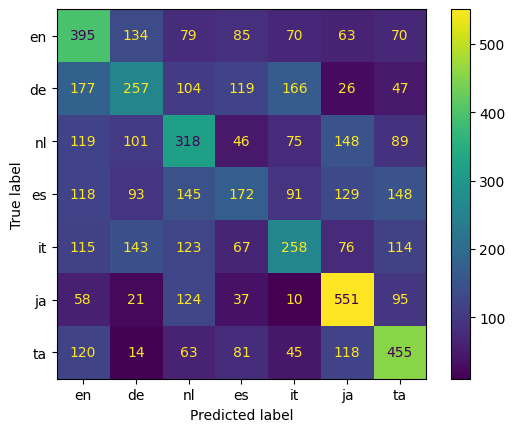

In [48]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)
disp.plot(xticks_rotation='horizontal')
plt.savefig(f'plots/models/{name}.png')